In [ ]:
import tensorflow as tf

# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-187c0b28-1207-55c6-7c9f-49a2307a684b)


In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory("/content/drive/MyDrive/Shroomies/BackendTeam/Train")
ds_training = tf.keras.preprocessing.image_dataset_from_directory("/content/drive/MyDrive/Shroomies/BackendTeam/Train", validation_split=0.2, subset="training", seed=123, shuffle=True)
ds_validation = tf.keras.preprocessing.image_dataset_from_directory("/content/drive/MyDrive/Shroomies/BackendTeam/Train", validation_split=0.2, subset="validation", seed=123)
ds_testing = tf.keras.preprocessing.image_dataset_from_directory("/content/drive/MyDrive/Shroomies/BackendTeam/Test")


Found 1826 files belonging to 2 classes.
Found 1826 files belonging to 2 classes.
Using 1461 files for training.
Found 1826 files belonging to 2 classes.
Using 365 files for validation.
Found 514 files belonging to 2 classes.


In [ ]:
print(ds_training)
print(ds_validation)
print(dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
import tensorflow_datasets as tfds
# batch size is basically dividing the subsets of the data into smaller chunks that a model can understand
batch_size = 32

dataset_name = dataset
class_names = dataset.class_names
print(class_names)

['edible', 'inedible']


In [ ]:
# standardizing our dataset
size = (512, 512)
ds_train = ds_training.map(lambda image, label: (tf.image.resize(image, size), label))
ds_val = ds_validation.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_testing.map(lambda image, label: (tf.image.resize(image, size), label))

In [ ]:
# Configuring dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

ds_train = ds_train.cache().prefetch(buffer_size=AUTOTUNE)
ds_val = ds_val.cache().prefetch(buffer_size=AUTOTUNE)

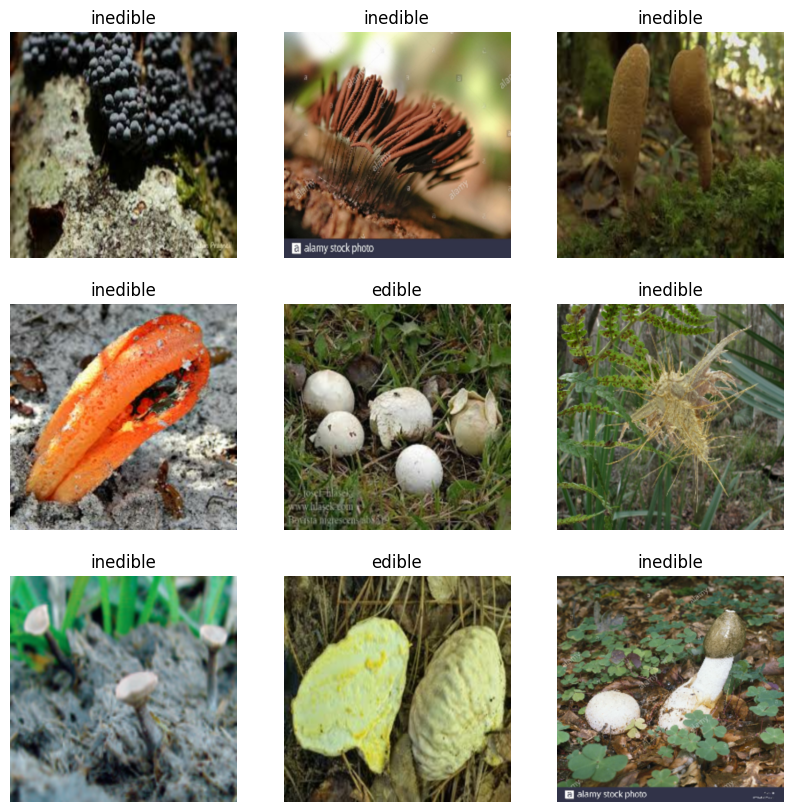

In [ ]:
# display images
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images, labels in ds_train.take(1):
  for i in range (9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
#we can do even more preprocessing to increase the instances of an image (basically get our moneys worth LETS GOOO)
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

image_augmentation = Sequential (
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(height_factor=(-0.2, -0.3), width_factor=(-0.2, -0.3), interpolation="bilinear"),
        layers.RandomContrast(factor=0.1),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    ],
    name="image"
)

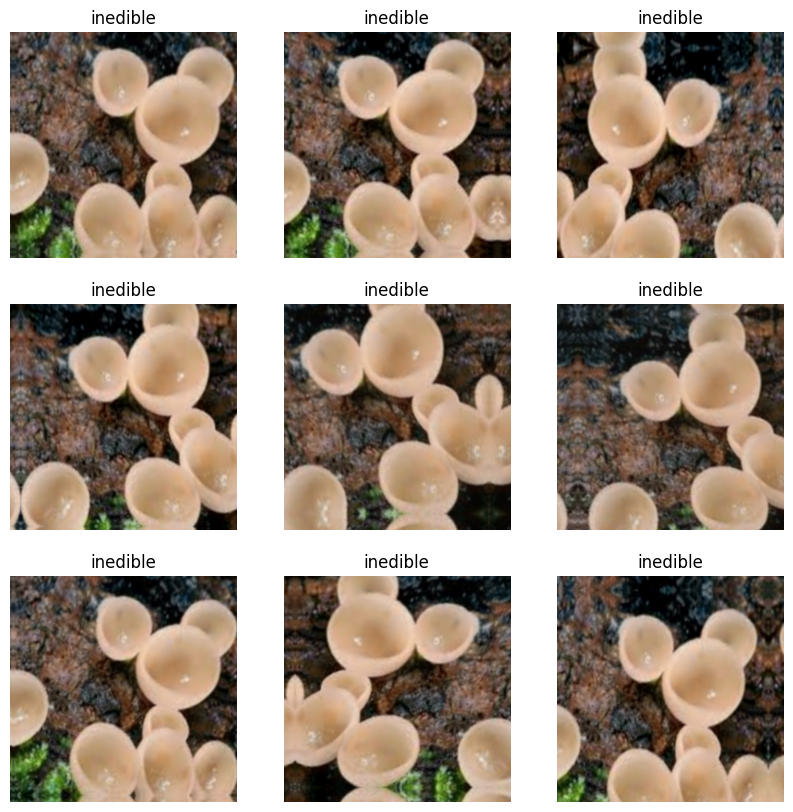

In [ ]:
#lets see what them bad boys look like now
import numpy as np

for images, labels in ds_train.take(1):
  plt.figure(figsize=(10,10))
  first_image = images[0]
  def f(x):
    return np.int_(x)
  f2 = np.vectorize(f)
  for i in range (9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = image_augmentation(
        tf.expand_dims(first_image, 0), training=True
    )
    plt.imshow(augmented_image[0].numpy().astype("int32"))
    plt.title(class_names[labels[0]]) #1 = poisonous
    plt.axis("off")

Apply Augmentations to dataset


In [ ]:
# ds_train = ds_train.map(lambda x, y: (image_augmentation(x, training=True), y))

Setting, training, testing the model


In [ ]:
#Instantiating our model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers


# Load the pre-trained ResNet50 model
pre_trained_Model = tf.keras.applications.ResNet50(
    include_top=False,               # Exclude the fully connected layers
    weights='imagenet',              # Use pre-trained weights from ImageNet
    input_tensor=None,               
    input_shape=(512, 512, 3),       # Input shape of your images
    pooling=None,                    # Use pooling or None as required
    classes=1000,                    # Number of classes (default for ImageNet, adjust if needed)
    classifier_activation='sigmoid'  # Activation for classification layer
)

pre_trained_Model.summary()

# Freeze the layers of the pre-trained model
for layer in pre_trained_Model.layers:
    layer.trainable = False

# Define the model architecture with ResNet50 as the base
shroomie_model = Sequential([
    pre_trained_Model,                 # Add ResNet50 as the feature extractor
    layers.GlobalAveragePooling2D(),   # Global pooling layer
    layers.BatchNormalization(),       # Batch normalization for stability
    layers.Flatten(),                  # Flatten the features
    layers.Dense(512, activation='relu'),  # Fully connected layers
    layers.Dropout(0.2),               # Dropout for regularization
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')  # Output layer (adjust activation if needed)
])

58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 512, 512, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 512, 512, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 256, 256, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 256, 256, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 256, 256, 128)     147584    
                                                              

In [ ]:
# Build the model
shroomie_model.build(input_shape=(None, 512, 512, 3))
shroomie_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 16, 16, 512)       14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0

In [ ]:
#Compile
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import *

METRICS=['accuracy', Precision(), Recall(), AUC()]

shroomie_model.compile(optimizer=Adam(learning_rate=0.0005), # try .0005 (higher learning rate means converges faster)
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=METRICS)

In [ ]:
ds_train, ds_val, ds_validation,

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#Stop training if val_loss doesn't improve after X batches
es = EarlyStopping(patience=2, monitor='val_loss') # change patience from 5 to 2

model_cp = ModelCheckpoint(filepath= "/content/drive/MyDrive/Shroomies/BackendTeam/Saved-Models/Saved_Model_Weights/shroomiesCNN_modelv1.H5",
                           monitor = "val_loss",
                           save_best_only = True,
                           save_weights_only = False,
                           verbose = 1,
                           mode='min',
                           save_freq='epoch',
                           initial_value_threshold=None)



In [ ]:
#For reference
#dataset = tf.keras.preprocessing.image_dataset_from_directory("/content/drive/MyDrive/Shroomies/BackendTeam/Train")
# ds_train = tf.keras.preprocessing.image_dataset_from_directory("/content/drive/MyDrive/Shroomies/BackendTeam/Train", validation_split=0.2, subset="training", seed=123)
# ds_validation = tf.keras.preprocessing.image_dataset_from_directory("/content/drive/MyDrive/Shroomies/BackendTeam/Train", validation_split=0.2, subset="validation", seed=123)
#
BATCH_SIZE = 32 #16-32

epochs = 100 # starts to overfit over 10 & wants to plot after each epoch (try 5)
history = shroomie_model.fit(
    ds_train,
    batch_size=BATCH_SIZE,
    validation_data = ds_val,
    epochs=epochs,
    callbacks=[es, model_cp]
)

# plot validation and accuracy and check which one is higher
# epoch of 100 is too high
# save the weights and push it to repo
# save each the model weight for each epoch

Epoch 1/100
46/46 [==============================] - ETA: 0s - loss: 3.4365 - accuracy: 0.7303 - precision: 0.7749 - recall: 0.8977 - auc: 0.5902
Epoch 1: val_loss improved from inf to 3.72348, saving model to /content/drive/MyDrive/Shroomies/BackendTeam/Saved-Models/Saved_Model_Weights/shroomiesCNN_modelv1.H5
46/46 [==============================] - 298s 6s/step - loss: 3.4365 - accuracy: 0.7303 - precision: 0.7749 - recall: 0.8977 - auc: 0.5902 - val_loss: 3.7235 - val_accuracy: 0.7534 - val_precision: 0.7534 - val_recall: 1.0000 - val_auc: 0.5056
Epoch 2/100
46/46 [==============================] - ETA: 0s - loss: 3.0745 - accuracy: 0.7673 - precision: 0.8231 - recall: 0.8747 - auc: 0.6849
Epoch 2: val_loss improved from 3.72348 to 2.41255, saving model to /content/drive/MyDrive/Shroomies/BackendTeam/Saved-Models/Saved_Model_Weights/shroomiesCNN_modelv1.H5
46/46 [==============================] - 46s 1s/step - loss: 3.0745 - accuracy: 0.7673 - precision: 0.8231 - recall: 0.8747 - au

In [ ]:
history.history

{'loss': [3.4364588260650635,
  3.0745222568511963,
  2.909161329269409,
  2.5678818225860596,
  2.535771369934082,
  2.740037679672241],
 'accuracy': [0.7303217053413391,
  0.7672826647758484,
  0.7802874445915222,
  0.8097193837165833,
  0.8049281239509583,
  0.7871320843696594],
 'precision': [0.7748607993125916,
  0.823070228099823,
  0.8374558091163635,
  0.8277822732925415,
  0.8780718445777893,
  0.8885542154312134],
 'recall': [0.8976958394050598,
  0.8746543526649475,
  0.8737327456474304,
  0.9391704797744751,
  0.8562211990356445,
  0.8156682252883911],
 'auc': [0.5902257561683655,
  0.684907853603363,
  0.7090669870376587,
  0.7060986757278442,
  0.7793900370597839,
  0.7861236333847046],
 'val_loss': [3.723480224609375,
  2.4125497341156006,
  2.3891661167144775,
  2.0462543964385986,
  2.8974153995513916,
  2.1724889278411865],
 'val_accuracy': [0.7534246444702148,
  0.8191781044006348,
  0.8027397394180298,
  0.8301370143890381,
  0.7808219194412231,
  0.835616409778595]

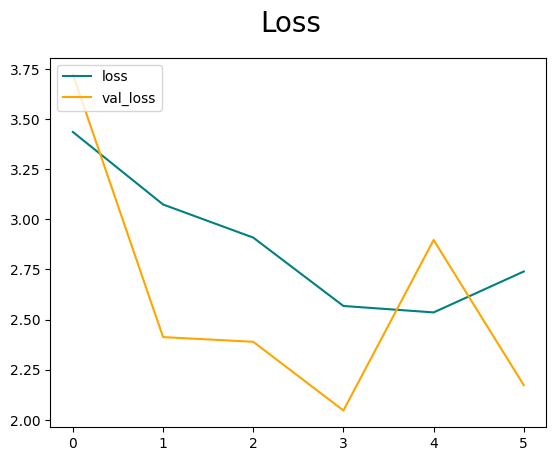

In [ ]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

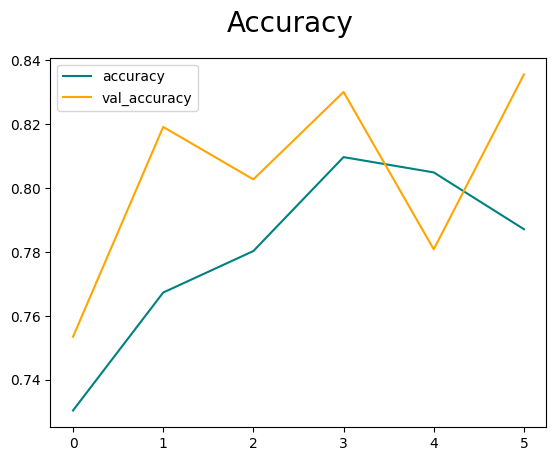

In [ ]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

Saving the model into our shared Shroomies drive


Save to our saved models files.

In [ ]:
from tensorflow.keras.models
shroomie_model.save('/content/drive/MyDrive/Shroomies/BackendTeam/Saved-Models/trained_Mushroom_model_V4_VGG16.keras')

Convert to TFLITE

In [ ]:
import pathlib

converter = tf.lite.TFLiteConverter.from_keras_model(shroomie_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()
# converter

#create the file path you want to save to
tflite_models_dir = pathlib.Path("/content/drive/MyDrive/Shroomies/BackendTeam/Saved-Models/tfLiteDR")
tflite_models_dir.mkdir(exist_ok = True, parents=True)

#safe the tf_lite_model
tflite_model_file = tflite_models_dir/"trainedModelV4_lite_VGG16.tflite"
tflite_model_file.write_bytes(tflite_model)


15324504